# **Project 1**

@To do 
* write a short description for the project
* define the goals
* brief explanation about regression and the libraries I'll use

In [5]:
# Setting up the environment

import numpy as np
import pandas as pd


In [3]:
data = np.load('data/proyecto_training_data.npy')

In [42]:
df = pd.DataFrame(data, columns=['SalePrice','OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage'])

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


The data consists of the following columns:

* **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.
* **OverallQual**: Overall material and finish quality, rates the overall material and finish of the house.
* **FloorSquareFeet**: First Floor square feet.
* **TotalRooms**: Total rooms above grade (does not include bathrooms)
* **YearBuilt**: Original construction date.
* **LotFrontage**: Linear feet of street connected to property.

In this dataset, **SalePrice** represents the label (the y value) our model must be trained to predict. The other columns are potential features (x values). 

As we can see, some columns are of float type, when based on the information they contain we can infer that they should correspond to integers, in this case we make the adjustment to set the correct types.

In [43]:
df[['TotalRooms','YearBuilt']] = df[['TotalRooms','YearBuilt']].astype(int)

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8,2003,65.0
1,181500.0,6.0,1262.0,6,1976,80.0
2,223500.0,7.0,920.0,6,2001,68.0
3,140000.0,7.0,961.0,7,1915,60.0
4,250000.0,8.0,1145.0,9,2000,84.0


### **Handling missing values**

Given that we are exploring the data, it's importat to review the missing values in the data. In order to do that, we can use the methods ```isnull()``` and ```sum()``` from pandas:

In [44]:
df.isnull().sum()

SalePrice            0
OverallQual          0
FloorSquareFeet      0
TotalRooms           0
YearBuilt            0
LotFrontage        259
dtype: int64

The output shows that the column **LotFrontage** has 259 missing values. Although there are different methods to handle these cases, we will use the approach of deleting the entire row for simplicity in this project.

In [40]:
df = df.dropna()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
1455,175000.0,6.0,953.0,7,1999,62.0
1456,210000.0,6.0,2073.0,7,1978,85.0
1457,266500.0,7.0,1188.0,9,1941,66.0
1458,142125.0,5.0,1078.0,5,1950,68.0
1459,147500.0,5.0,1256.0,6,1965,75.0


### **Exploring the data**

Now that we've handled the missing values, we can explore the data. To do so, we use the ```describe()``` method to check the **mean**, **min** and **max** values.

In [45]:
df.describe()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


At first glance, we can observe that the mean of the sale prices is around 181000, while the standard deviation is around 79000, indicating a large variation in prices. To have a clearer idea of the price distribution, we can visualize the data using histograms and box plots as follows:

/var/folders/bw/5rhpjqf916g25y1gn5gw3nzr0000gn/T/ipykernel_6683/2049416241.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


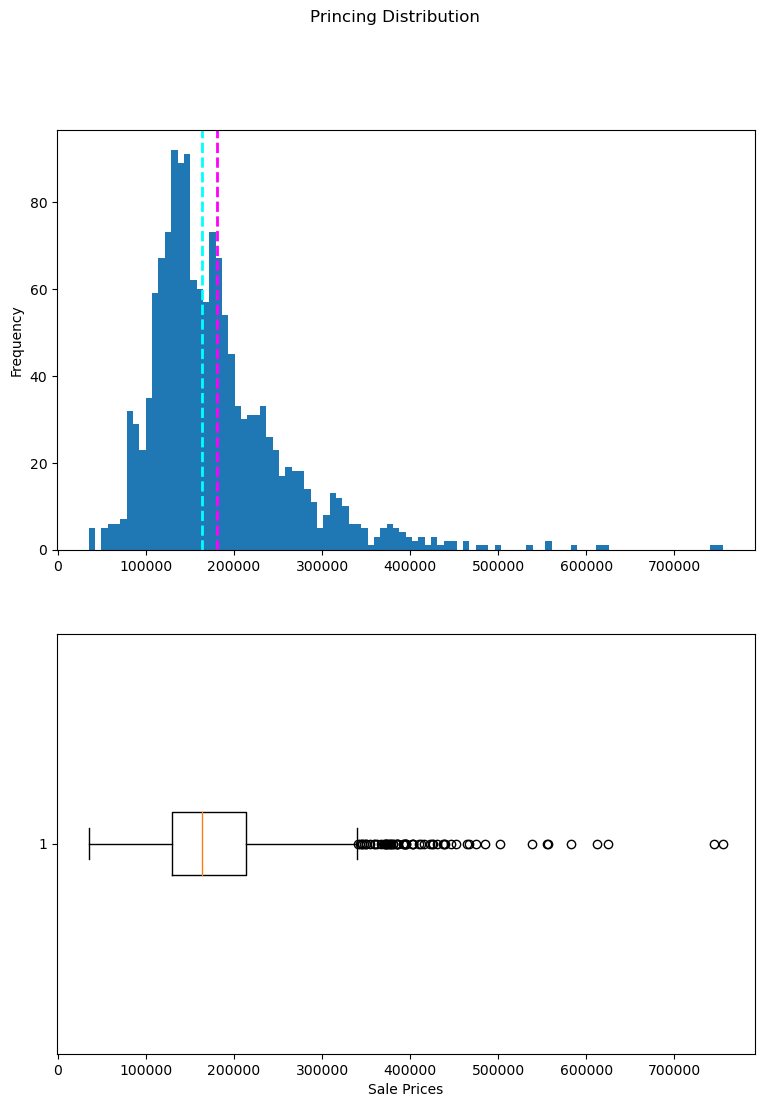

In [52]:
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the notebook
%matplotlib inline

# Get the label column
label = df['SalePrice']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Sale Prices')

# Add a title to the Figure
fig.suptitle('Princing Distribution')

# Show the figure
fig.show()

In [51]:
import seaborn as sns 

sns.displot(data=df, x='SalePrice')